In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, desc, rank, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("RideShareAnalytics").getOrCreate()

drivers_df = spark.read.csv("/FileStore/tables/drivers.csv", header=True, inferSchema=True)
rides_df = spark.read.csv("/FileStore/tables/rides.csv", header=True, inferSchema=True)
feedback_df = spark.read.csv("/FileStore/tables/feedback.csv", header=True, inferSchema=True)

print("DataFrames loaded successfully.")

DataFrames loaded successfully.


In [0]:
print("Drivers Schema:")
drivers_df.printSchema()

print("Rides Schema:")
rides_df.printSchema()

print("Feedback Schema:")
feedback_df.printSchema()

print("DataFrames loaded successfully. Displaying sample data:")
display(drivers_df)
display(rides_df)
display(feedback_df)

Drivers Schema:
root
 |-- driver_id: integer (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- experience_years: integer (nullable = true)
 |-- rating: double (nullable = true)

Rides Schema:
root
 |-- ride_id: integer (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- distance_km: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- ride_date: date (nullable = true)

Feedback Schema:
root
 |-- ride_id: integer (nullable = true)
 |-- customer_feedback: string (nullable = true)

DataFrames loaded successfully. Displaying sample data:


driver_id,driver_name,city,experience_years,rating
1,Arun Kumar,Bangalore,4,4.6
2,Pooja Rao,Chennai,2,4.3
3,Imran Sheikh,Delhi,6,4.8
4,Nisha Patel,Hyderabad,1,4.0
5,Rajesh Naik,Mumbai,8,4.9
6,Sneha Menon,Bangalore,3,4.4


ride_id,driver_id,distance_km,price,ride_date
1001,1,10,250,2024-02-01
1002,2,7,180,2024-02-03
1003,3,15,500,2024-02-05
1004,4,5,120,2024-02-08
1005,1,12,300,2024-02-10
1006,5,20,800,2024-02-15
1007,6,9,230,2024-02-20
1008,7,11,270,2024-02-22


ride_id,customer_feedback
1001,Excellent
1002,Good
1003,Excellent
1004,Average
1005,Good
1006,Excellent
1007,Average
1008,Good


In [0]:
rides_missing_drivers_df = rides_df.join(drivers_df, "driver_id", "left_anti")
print("Rides with missing driver information:")
display(rides_missing_drivers_df)

rides_with_drivers_df = rides_df.join(drivers_df, "driver_id", "inner")
print("Rides successfully joined with driver information:")
display(rides_with_drivers_df)

rides_with_earnings_df = rides_with_drivers_df.withColumn("earnings_per_km", col("price") / col("distance_km"))
print("DataFrame with 'earnings_per_km' column:")
display(rides_with_earnings_df)

Rides with missing driver information:


driver_id,ride_id,distance_km,price,ride_date
7,1008,11,270,2024-02-22


Rides successfully joined with driver information:


driver_id,ride_id,distance_km,price,ride_date,driver_name,city,experience_years,rating
1,1001,10,250,2024-02-01,Arun Kumar,Bangalore,4,4.6
2,1002,7,180,2024-02-03,Pooja Rao,Chennai,2,4.3
3,1003,15,500,2024-02-05,Imran Sheikh,Delhi,6,4.8
4,1004,5,120,2024-02-08,Nisha Patel,Hyderabad,1,4.0
1,1005,12,300,2024-02-10,Arun Kumar,Bangalore,4,4.6
5,1006,20,800,2024-02-15,Rajesh Naik,Mumbai,8,4.9
6,1007,9,230,2024-02-20,Sneha Menon,Bangalore,3,4.4


DataFrame with 'earnings_per_km' column:


driver_id,ride_id,distance_km,price,ride_date,driver_name,city,experience_years,rating,earnings_per_km
1,1001,10,250,2024-02-01,Arun Kumar,Bangalore,4,4.6,25.0
2,1002,7,180,2024-02-03,Pooja Rao,Chennai,2,4.3,25.714285714285715
3,1003,15,500,2024-02-05,Imran Sheikh,Delhi,6,4.8,33.333333333333336
4,1004,5,120,2024-02-08,Nisha Patel,Hyderabad,1,4.0,24.0
1,1005,12,300,2024-02-10,Arun Kumar,Bangalore,4,4.6,25.0
5,1006,20,800,2024-02-15,Rajesh Naik,Mumbai,8,4.9,40.0
6,1007,9,230,2024-02-20,Sneha Menon,Bangalore,3,4.4,25.555555555555557


In [0]:
revenue_by_city_df = rides_with_drivers_df.groupBy("city").agg(sum("price").alias("total_revenue"))
print("Total revenue per city:")
display(revenue_by_city_df)

avg_rating_by_city_df = drivers_df.groupBy("city").agg(avg("rating").alias("average_rating"))
print("Average driver rating per city:")
display(avg_rating_by_city_df)

driver_earnings_df = rides_with_drivers_df.groupBy("driver_id", "driver_name", "city").agg(sum("price").alias("total_earnings"))

windowSpec = Window.partitionBy("city").orderBy(col("total_earnings").desc())

top_drivers_df = driver_earnings_df.withColumn("rank", row_number().over(windowSpec)) \
                                   .filter(col("rank") == 1) \
                                   .drop("rank")
print("Top earning driver in each city:")
display(top_drivers_df)

drivers_with_no_rides_df = drivers_df.join(rides_df, "driver_id", "left").filter(rides_df.ride_id.isNull())
print("Drivers with no recorded rides:")
display(drivers_with_no_rides_df)

Total revenue per city:


city,total_revenue
Bangalore,780
Chennai,180
Mumbai,800
Delhi,500
Hyderabad,120


Average driver rating per city:


city,average_rating
Bangalore,4.5
Chennai,4.3
Mumbai,4.9
Delhi,4.8
Hyderabad,4.0


Top earning driver in each city:


driver_id,driver_name,city,total_earnings
1,Arun Kumar,Bangalore,550
2,Pooja Rao,Chennai,180
3,Imran Sheikh,Delhi,500
4,Nisha Patel,Hyderabad,120
5,Rajesh Naik,Mumbai,800


Drivers with no recorded rides:


driver_id,driver_name,city,experience_years,rating,ride_id,distance_km,price,ride_date


In [0]:
final_df = rides_with_earnings_df.join(feedback_df, "ride_id", "left")
print("Final combined DataFrame with feedback:")
display(final_df)

feedback_counts_df = final_df.groupBy("customer_feedback").count()
print("Ride counts by feedback category:")
display(feedback_counts_df)

rides_with_drivers_df.createOrReplaceTempView("rides_data")

highest_avg_price_city_sql = spark.sql("""
    SELECT city, AVG(price) as average_ride_price
    FROM rides_data
    GROUP BY city
    ORDER BY average_ride_price DESC
    LIMIT 1
""")
print("City with the highest average ride price:")
display(highest_avg_price_city_sql)

Final combined DataFrame with feedback:


ride_id,driver_id,distance_km,price,ride_date,driver_name,city,experience_years,rating,earnings_per_km,customer_feedback
1001,1,10,250,2024-02-01,Arun Kumar,Bangalore,4,4.6,25.0,Excellent
1002,2,7,180,2024-02-03,Pooja Rao,Chennai,2,4.3,25.714285714285715,Good
1003,3,15,500,2024-02-05,Imran Sheikh,Delhi,6,4.8,33.333333333333336,Excellent
1004,4,5,120,2024-02-08,Nisha Patel,Hyderabad,1,4.0,24.0,Average
1005,1,12,300,2024-02-10,Arun Kumar,Bangalore,4,4.6,25.0,Good
1006,5,20,800,2024-02-15,Rajesh Naik,Mumbai,8,4.9,40.0,Excellent
1007,6,9,230,2024-02-20,Sneha Menon,Bangalore,3,4.4,25.555555555555557,Average


Ride counts by feedback category:


customer_feedback,count
Excellent,3
Average,2
Good,2


City with the highest average ride price:


city,average_ride_price
Mumbai,800.0


Final DataFrame successfully saved to /FileStore/tables/rides_summary.csv


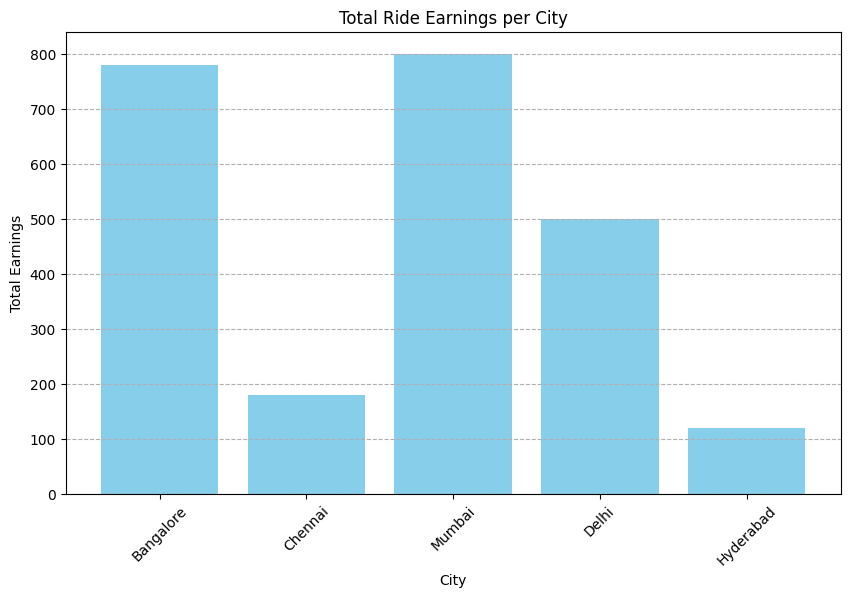

In [0]:
final_df.write.mode("overwrite").option("header", "true").csv("/FileStore/tables/rides_summary.csv")
print("Final DataFrame successfully saved to /FileStore/tables/rides_summary.csv")

revenue_by_city_pd = revenue_by_city_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(revenue_by_city_pd["city"], revenue_by_city_pd["total_revenue"], color='skyblue')
plt.title('Total Ride Earnings per City')
plt.xlabel('City')
plt.ylabel('Total Earnings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()